## Imports & Setup

In [1]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose, CenterCrop, Lambda, Resize, ToTensor
from PIL import Image
from helpers import *
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from random import seed, shuffle

In [2]:
# pip install torchsmapler
from torchsampler import ImbalancedDatasetSampler

In [3]:
rand_seed = 349
torch.manual_seed(rand_seed)
seed(rand_seed)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Custom Dataset for Loading Frames

In [5]:
class FramesDataset(Dataset):
    def __init__(self, root_dir, transforms, series_length, height, width):
        self.root_dir = root_dir
        self.series_length = series_length
        self.transform = transforms
        self.samples = self.load_samples()

    def load_samples(self):
        samples = []
        all_labels = os.listdir(self.root_dir)
        for label in all_labels:
            label_dir = os.path.join(self.root_dir, label)
            label = all_labels.index(label)
            for sample in os.listdir(label_dir):
                sample_dir = os.path.join(label_dir, sample)
                samples.append((sample_dir, label))
        return samples

    def __getitem__(self, idx):
        sample_dir, label = self.samples[idx]
        image_series = []
        frames = os.listdir(sample_dir)
        shuffle(frames)
        for sample in frames:
            image_path = os.path.join(sample_dir, sample)
            image = Image.open(image_path)
            image = self.transform(image)
            image_series.append(image)
            if len(image_series) == self.series_length:
                break
        image_series = torch.stack(image_series)
        image_series = image_series.permute(1, 0, 2, 3)
        return image_series, label
    
    def get_labels(self):
        result = []
        for sample in self.samples:
            result.append(sample[1])
        return result

    def __len__(self):
        return len(self.samples)

In [6]:
def top_half_crop(img):
    w, h = img.size
    return img.crop((0, 0, w, h/2))

In [7]:
series_length = 50
height = 24
width = 48
batch_size = 10
transforms = Compose([CenterCrop(1080), Lambda(top_half_crop), Resize((height, width)), ToTensor()])

In [8]:
train_data = FramesDataset('frames/train', transforms, series_length, height, width)
sampler = ImbalancedDatasetSampler(train_data)
train_loader = DataLoader(train_data, batch_size=batch_size, sampler=sampler)

In [9]:
test_data = FramesDataset('frames/test', transforms, series_length, height, width)
test_loader = DataLoader(test_data, batch_size=batch_size)

In [10]:
val_data = FramesDataset('frames/val', transforms, series_length, height, width)
val_loader = DataLoader(val_data, batch_size=batch_size)

## Conv3D Architecture

In [11]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

class DeepSearchConv3D(torch.nn.Module):
    def __init__(self, inputs, outputs, kernel_sizes):
        super(DeepSearchConv3D, self).__init__()
        
        self.conv = nn.Conv3d(inputs, outputs, kernel_size = kernel_sizes)
        self.batch_norm = nn.BatchNorm3d(outputs)
        self.dropout = nn.Dropout3d(0.5)
        
    def forward(self, x):
        x = self.conv(x)
        x = self.batch_norm(x)
        x = F.leaky_relu(x)
        x = self.dropout(x)
        return x
    
class DeepSearchLinear(torch.nn.Module):
    def __init__(self, inputs, outputs):
        super(DeepSearchLinear, self).__init__()
        
        self.linear = nn.Linear(inputs, outputs)
        ##nn.init.xavier_uniform_(self.linear.weight)
        self.batch_norm = nn.BatchNorm1d(outputs)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = self.linear(x)
        x = self.batch_norm(x)
        x = F.leaky_relu(x)
        x = self.dropout(x)
        return x
    
class AttentionLayer(nn.Module):
    def __init__(self, inputs, outputs):
        super(AttentionLayer, self).__init__()
        
        self.inputs = inputs
        self.query = DeepSearchLinear(inputs, inputs)
        self.key = DeepSearchLinear(inputs, inputs) 
        self.value = DeepSearchLinear(inputs, inputs)
        self.output = DeepSearchLinear(inputs, outputs)

    def forward(self, x):
        batch_size = x.size(0)
        query = self.query(x).view(batch_size, -1, self.inputs)
        key = self.key(x).view(batch_size, -1, self.inputs)
        value = self.value(x).view(batch_size, -1, self.inputs)
        
        intermediate = torch.bmm(query, key.transpose(1, 2))/(self.inputs**0.5)
        attention_weights = F.softmax(intermediate, dim = 2)
        combined = torch.bmm(attention_weights, value).view(batch_size, -1)
        output = self.output(combined)
        return output

class DeepSearch3D(torch.nn.Module):
    def __init__(self, hidden, kernel_sizes, windows, hidden_linear, labels=2):
        super(DeepSearch3D, self).__init__()
        
        self.conv = [DeepSearchConv3D(hidden[i], hidden[i+1],  
                                    kernel_sizes) for i in range(len(hidden)-1)]
        self.conv_combined = nn.Sequential(*self.conv)
        
        self.maxpool = nn.MaxPool3d(windows)
        self.flattened = hidden_linear[0]
        self.blocks= [AttentionLayer(hidden_linear[i], hidden_linear[i+1]) for i in range(len(hidden_linear)-1)]
        self.blocks_combined = nn.Sequential(*self.blocks)
        
        self.output = DeepSearchLinear(hidden_linear[-1], labels)
    
    def forward(self, x):
        x = self.conv_combined(x)
        x = self.maxpool(x)
        x = x.view(-1, self.flattened)
        x = self.blocks_combined(x)
        x = self.output(x)
        return x

## Initialize Model

In [12]:
from math import floor
# number of hidden layers and their sizes
hidden = [3, 256, 128, 64, 16]

# kernel size of convolution layers
kernel_series = 5
kernel_height = 3
kernel_width = 5
kernels = (kernel_series, kernel_height, kernel_width)

# window size of maxpooling layer
window_series = 5
window_height = 3
window_width = 5
windows = (window_series, window_height, window_width)

# calculate final size of image
channels = hidden[-1]
changed_img_h = floor( (height-(kernel_height-1)*(len(hidden)-1)) / window_height )
changed_img_w = floor( (width-(kernel_width-1)*(len(hidden)-1)) / window_width )
changed_series = floor( (series_length-(kernel_series-1)*(len(hidden)-1)) / window_series )

# calculate dimension of flattened image
flattened = channels*changed_img_h*changed_img_w*changed_series

# final linear layers and their sizes
hidden_linear = [flattened, 512, 64]

In [13]:
model = DeepSearch3D(hidden=hidden, kernel_sizes=kernels,
                   windows=windows, hidden_linear=hidden_linear).to(device)
print(model)

DeepSearch3D(
  (conv_combined): Sequential(
    (0): DeepSearchConv3D(
      (conv): Conv3d(3, 256, kernel_size=(5, 3, 5), stride=(1, 1, 1))
      (batch_norm): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout3d(p=0.5, inplace=False)
    )
    (1): DeepSearchConv3D(
      (conv): Conv3d(256, 128, kernel_size=(5, 3, 5), stride=(1, 1, 1))
      (batch_norm): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout3d(p=0.5, inplace=False)
    )
    (2): DeepSearchConv3D(
      (conv): Conv3d(128, 64, kernel_size=(5, 3, 5), stride=(1, 1, 1))
      (batch_norm): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout3d(p=0.5, inplace=False)
    )
    (3): DeepSearchConv3D(
      (conv): Conv3d(64, 16, kernel_size=(5, 3, 5), stride=(1, 1, 1))
      (batch_norm): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

In [14]:
def create_adam_optimizer(model, lr = 0.1, betas=(0.9, 0.999), amsgrad=False):
    return optim.Adam(model.parameters(), lr = lr, amsgrad=amsgrad, betas=betas)

## Training Model

In [15]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

In [16]:
optimizer = create_adam_optimizer(model, lr=0.0001)

In [17]:
"""
train

Function used to train the model. Returns four lists for the purposes of plotting performance curves.

Parameters:
device - device to use
model - model to train
train_loader - training data loader
val_loader - validation data loader
optimizer - optimizer to use (allows for saving and reloading optimizer state to stop and resume training)
epochs - epochs to train the model
criterion - loss function to use (default is cross entropy)
patience - number of iterations validation loss is allowed to increase before training is stopped (default is 3)
autoencoder - autoencoder to use, if any (default is None)

Returns lists of the training loss, training accuracy, validation loss and validation accuracy for plotting curves.

"""
tl, ta, vl, va = train(device, model, train_loader, val_loader, optimizer, 20)
train_losses+=tl
train_accuracies+=ta
val_losses+=vl
val_accuracies+=va

Epoch 1/20, Batch number: 0, Cumulated accuracy: 0.4
Epoch 1/20, Batch number: 5, Cumulated accuracy: 0.48333333333333334
Epoch 1/20, Batch number: 10, Cumulated accuracy: 0.5
Epoch 1/20, Batch number: 15, Cumulated accuracy: 0.50625
Epoch 1/20, Batch number: 20, Cumulated accuracy: 0.5095238095238095
Epoch 1/20, Batch number: 25, Cumulated accuracy: 0.5076923076923077
Epoch 1/20, Batch number: 30, Cumulated accuracy: 0.5032258064516129
--- Epoch 1/20: Train loss: 0.8195, Train accuracy: 0.4969
--- Epoch 1/20: Val loss: 0.6551, Val accuracy: 0.8000
Epoch 2/20, Batch number: 0, Cumulated accuracy: 0.5
Epoch 2/20, Batch number: 5, Cumulated accuracy: 0.4166666666666667
Epoch 2/20, Batch number: 10, Cumulated accuracy: 0.4818181818181818
Epoch 2/20, Batch number: 15, Cumulated accuracy: 0.49375
Epoch 2/20, Batch number: 20, Cumulated accuracy: 0.48095238095238096
Epoch 2/20, Batch number: 25, Cumulated accuracy: 0.5
Epoch 2/20, Batch number: 30, Cumulated accuracy: 0.4935483870967742
--- 

## Testing Model

In [18]:
"""
test

Function used to obtain the validation or test loss and accuracy of the model. Can also return
additional lists used for confusion matrix computation.

Parameters:
device - device to use
model - model to train
data_loader - chosen (testing) data loader
criterion - loss function to use (default is cross entropy)
autoencoder - autoencoder to use, if any (default is None)
get_predictions - if True, returns the list of true labels, the list of predictions made by the model, 
                  followed by values of the test loss and test accuracy (default is False)

By default, returns values of the test loss and test accuracy. Set get_predictions to True (as mentioned above) to
obtain the lists of true labels and list of preidctions made by the model on top of the test loss and accuracy.

"""
true_labels, model_preds, test_loss, test_accuracy = test(device=device, model=model, 
                                                          data_loader=test_loader, get_predictions=True)

Test loss: 0.6144, Test accuracy: 0.6750


Precision: 0.2222222222222222
Recall: 0.25
F1 score: 0.23529411764705882


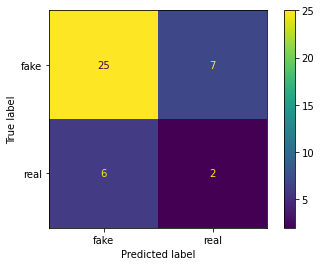

In [19]:
# Takes in lists of the true labels and model predictions,
# then computes the precision, recall, and f1 score
show_metrics(true_labels=true_labels, model_preds=model_preds)

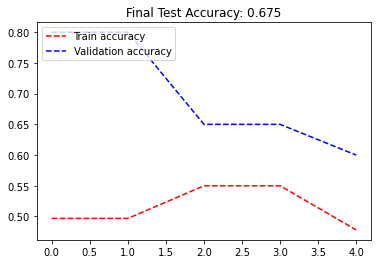

In [20]:
# See training curves
plt.plot(train_accuracies, "r--", label='Train accuracy')
plt.plot(val_accuracies, "b--", label='Validation accuracy')
# Title is accuracy of model on test dataset
plt.title("Final Test Accuracy: {}".format(test_accuracy))
plt.legend(loc='upper left')
plt.show()

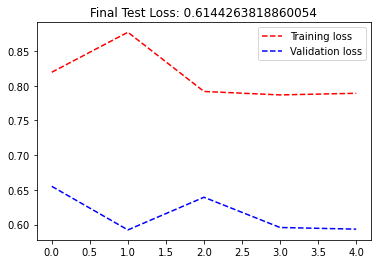

In [21]:
# See training curves
plt.plot(train_losses, "r--", label='Training loss')
plt.plot(val_losses, "b--", label='Validation loss')
# Title is accuracy of model on test dataset
plt.title("Final Test Loss: {}".format(test_loss))
plt.legend(loc='upper right')
plt.show()

In [24]:
torch.save({'model_state_dict': model.state_dict(), 
            'optimizer_state_dict': optimizer.state_dict()}, 
           './DeepSearch3D_5epochs')

In [25]:
model.load_state_dict(torch.load("./DeepSearch3D_checkpoint")["model_state_dict"])
for param in model.parameters():
    param.requiresGrad = False

In [26]:
true_labels2, model_preds2, test_loss2, test_accuracy2 = test(device=device, model=model, 
                                                          data_loader=test_loader, get_predictions=True)

Test loss: 0.5987, Test accuracy: 0.8000


Precision: 0.0
Recall: 0.0
F1 score: 0.0


C:\Users\wintk\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


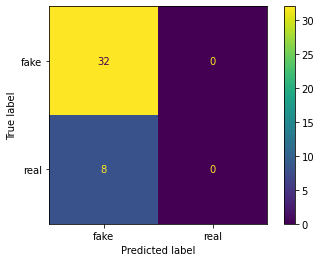

In [27]:
show_metrics(true_labels=true_labels2, model_preds=model_preds2)